In [1]:
import pyro
import torch
import wandb
import os

from inference.bayesian.models import TorchModel, BayesianModel
from inference.bayesian.utils import plot_forecast
from inference.inference import inference
from ESN.utils import run_esn

In [2]:
config = {
            "dataset": "spain",
            "model_widths": [512, 1],
            "activation": "tanh",
            "distributions": ["unif", "unif", "gauss"],
            "parameters": [[0,1],[0,10]],
            "dim_reduction": False,
            "num_chains": 2,
            "num_samples": 8000,
            "inference": "mcmc",
            "plot": False,
            "sweep": False
            }

os.environ["WANDB_MODE"]="offline"
wandb.init(project="bayes_rc", config=config)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]='0'

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Run ESN on dataset and produce embeddings with or without dimensionality reduction according to `dim_reduction`

In [4]:
Ytr, train_embedding, Yval, val_embedding, Yte, test_embedding, diffXte, diffYte = run_esn(config.dataset, device, dim_reduction=config.dim_reduction)

Tr: 907, Val: 455, Te: 455


# Markov Chain Monte Carlo


Perform SSVS on embeddings with no dimensionality reduction.

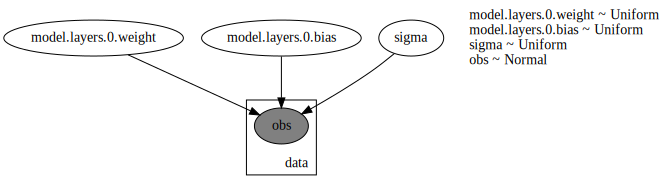

In [5]:
torch_model = TorchModel(config.model_widths, config.activation).to(device)
mcmc_model = BayesianModel(torch_model, config, device)
mcmc_model.render_model(model_args=(train_embedding[0], Ytr[0]))

In [6]:
# Quantiles
quantiles = [0, 0.005]
for n in range(39):
    quantiles.append(0.025*(n+1))
quantiles.append(0.995)

In [7]:
# Run Markov chains and collect diagnostics
predictive, diagnostics = inference(config, mcmc_model, None,
                                    X_train=train_embedding, Y_train=Ytr,
                                    X_val=val_embedding, Y_val=Yval, 
                                    X_test=test_embedding, Y_test=Yte,
                                    quantiles=quantiles)

Sample: 100%|██████████| 8000/8000 [6:16:37,  2.82s/it, step size=1.56e-02, acc. prob=0.973]


Checking convergence...
Chain 0 completed.
Chain 1 completed.
MCMC converged at 0 steps.


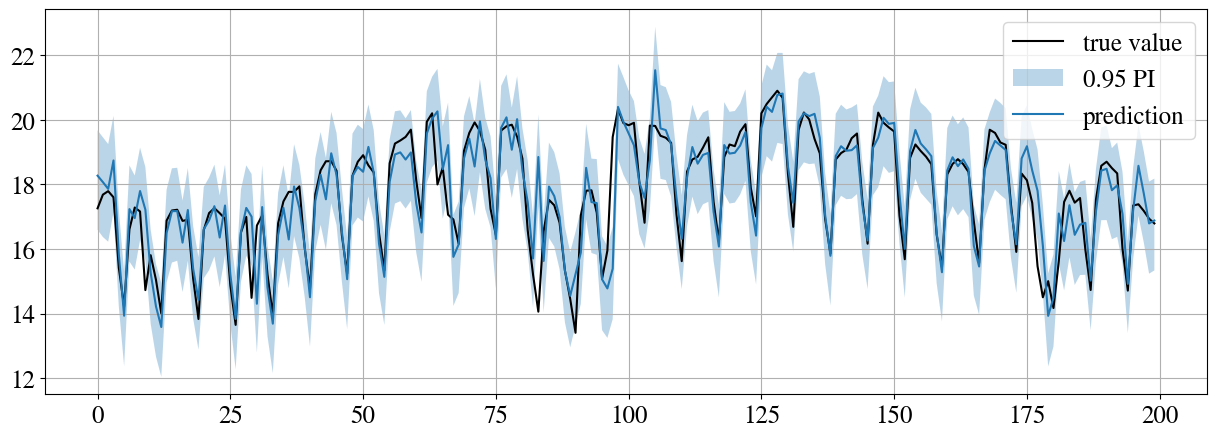

In [8]:
CI = [diagnostics["new_quantiles"][2], diagnostics["new_quantiles"][-2]]

plot_forecast(predictive, Yte, diffXte.squeeze(), diffYte.squeeze(), CI, "mcmc")

In [13]:
for k, v in diagnostics.items():
    print(k)

step_size
acceptance_rate
train_time
autocorrelation
gelman_rubin
effective_sample_size
width95
width99
mse
cal_error
new_cal_error
width
new_width
coverage
avg_length
new_coverage
new_avg_length
new_mse
crps
new_crps


In [14]:
print(diagnostics['gelman_rubin'])

{'model.layers.0.bias': tensor(9.6278), 'model.layers.0.weight': tensor(53.0830), 'sigma': tensor(54.2073)}


In [15]:
print("effective sample size: ", diagnostics['effective_sample_size'])

effective sample size:  {'model.layers.0.bias': tensor(1.0405), 'model.layers.0.weight': tensor([ 72.4706,  75.3831,  76.3006,  ...,  99.6259,  89.6037, 102.8600]), 'sigma': tensor(1.3231)}


In [11]:
print("training time: ", diagnostics['train_time'])
# print("effective sample size: ", diagnostics['effective_sample_size'])
print("calibration error: ", diagnostics['cal_error'])
print("Continuous ranked probability score: ", diagnostics['crps'])
print("Mean Squared Error: ", diagnostics['mse'])

training time:  1017.4688439685001
calibration error:  13.754522658175986
Continuous ranked probability score:  0.2809542119503021
Mean Squared Error:  0.29989374


In [21]:
# to reload a package or method
import sys, importlib

importlib.reload(sys.modules['bayesian.utils'])

from inference.bayesian.utils import plot_forecast

In [23]:
# to save a session
import dill

dill.dump_session('dump/notebook_16122022.db')

In [ ]:
# to load a session
dill.load_session('notebook_env.db')

In [13]:
predictive['obs'].shape

torch.Size([1988, 3431])